In [112]:
#高値,安値,始値,終値 から 次の時刻の高値を予測する
%matplotlib inline
import chainer
from chainer import optimizers, cuda
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from net import Net,MoreLayersNet

In [113]:
n_epoch = 1000000 #エポック
batchsize = 578 #バッチサイズ
bprop_len = 10 #何回でバックプロパゲーションを打ち切るか(truncate)
n_units = 2000 #中間層のユニット数
grad_clip = 5 #誤差関数の絶対値をこの値に制限する
use_gpu = True #GPUを使うかどうか

In [114]:
xp = cuda.cupy if use_gpu is True else np

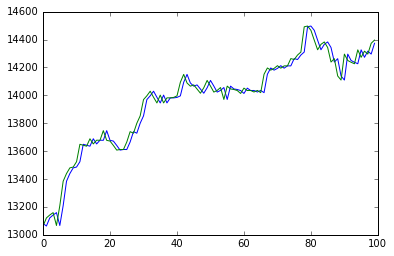

In [115]:
train_data_x = []
train_data_y = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    train_data_x.append([row[i] for i in range(1,5)])
    train_data_y.append([row[1]])
train_data_x = np.asarray(train_data_x, dtype=np.float32)
train_data_y = np.asarray(train_data_y, dtype=np.float32)
train_data_x = train_data_x[1000:5000]
train_data_y = train_data_y[1001:5001]
plt.plot(train_data_x[:100][:,0])
plt.plot(train_data_y[:100])

In [116]:
#ネットワークを試す関数
def evaluate(model):
    evaluator = model.copy()
    evaluator.reset_state()
    output = []
    plt.plot(train_data_x)
    for t in train_data_x:
        t = chainer.Variable(xp.array([t],dtype=np.float32))
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [117]:
model = Net(4, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
#optimizer = optimizers.Adam()
optimizer = optimizers.SGD(lr=1e-3)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([train_data_x[(jump * j + i) % length] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([train_data_y[(jump * j + i) % length] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 100 == 0:
            print('epoch {}, error {}, alpha{}'.format(epoch, loss_data / length, optimizer.lr))

        loss.append(loss_data / length)
        loss_data = 0
        #model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()
    

epoch 100, error 2543211.25, alpha0.001
epoch 200, error 2518957.0, alpha0.001
epoch 300, error 2464243.75, alpha0.001
epoch 400, error 2506503.25, alpha0.001
epoch 500, error 2497887.25, alpha0.001
epoch 600, error 2460433.0, alpha0.001
epoch 700, error 2473957.5, alpha0.001
epoch 800, error 2527851.5, alpha0.001
epoch 900, error 2481581.0, alpha0.001
epoch 1000, error 2462618.0, alpha0.001
epoch 1100, error 2497775.25, alpha0.001
epoch 1200, error 2456746.0, alpha0.001
epoch 1300, error 2426728.5, alpha0.001
epoch 1400, error 2480889.75, alpha0.001
epoch 1500, error 2494959.5, alpha0.001
epoch 1600, error 2430097.0, alpha0.001
epoch 1700, error 2460742.25, alpha0.001
epoch 1800, error 2470161.0, alpha0.001
epoch 1900, error 2422548.0, alpha0.001
epoch 2000, error 2399634.25, alpha0.001
epoch 2100, error 2480624.5, alpha0.001
epoch 2200, error 2453897.5, alpha0.001
epoch 2300, error 2397328.25, alpha0.001
epoch 2400, error 2436661.75, alpha0.001
epoch 2500, error 2426040.0, alpha0.001

KeyboardInterrupt: 

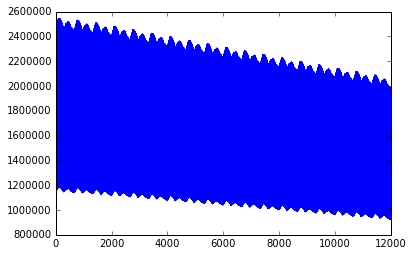

In [118]:
plt.plot(loss[0:12000])

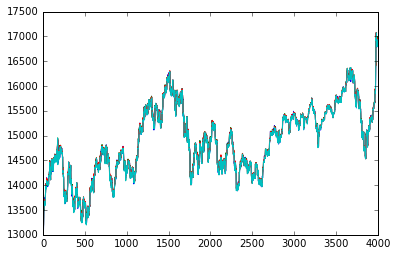

In [119]:
output = evaluate(model)

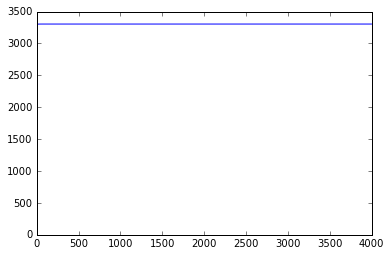

In [120]:
plt.plot(output[0:30000])